<a href="https://colab.research.google.com/github/pruce99/KmeansAutoencoder/blob/main/Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install validclust


In [ ]:
import tensorflow as tf
from sklearn.metrics import silhouette_score 
from sklearn.metrics import pairwise_distances 
from validclust import dunn
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [ ]:
(x_train, y_train), (x_test, y_test)  =tf.keras.datasets.cifar10.load_data()


170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
x_train = x_train.reshape(50000,3072)
x_train = x_train/255
x_test = x_test.reshape(10000,3072)
x_test = x_test/255


In [ ]:
Clustersize = 10
Centroids = np.random.rand(Clustersize,3072)


In [ ]:
Centroids.shape


(10, 3072)

In [ ]:
temp = []
newCentroids = []
lists = [[] for _ in range(Clustersize)]


In [ ]:
max_iterations = 100
labels = np.zeros((x_test.shape[0]))
labels.shape
# labels = np.zeros((x_train.shape[0]))

(10000,)

In [ ]:
for l in range(0,max_iterations):
  lists = [[] for _ in range(Clustersize)]
  for x in range(0, x_test.shape[0]-1): # replace with x_train if you want to find the clusters of the x_train dataset
    for y in range(0, Centroids.shape[0]): #For every datapoint in test, we find the distance from all the centroids
      dist = distance.euclidean(x_test[x], Centroids[y]) # finds the euclidean distance the x_test datapoint and the centroids
      temp.append(dist)
    min_value = min(temp) #finds the minimum value of the datapoints present in temp
    min_index = temp.index(min_value) # finds the index  where the minimum value lies in 
    temp = [] # Emptying temp array for next iteration
    lists[min_index].append(x_test[x]) # min_index in this case will be the label
    #We append the datapoint to list of label
    labels[x] = min_index
  for index, cluster in enumerate(lists):
    t = np.asarray(cluster) #we find the mean of each cluster list
    Centroids[index] = np.mean(t, axis=0) #The mean of each list will be the new centroids
  if(l%10==0):
    print("Iteration ",l," done") # Denoting that every 10th iteration is done



Iteration  0  done
Iteration  10  done
Iteration  20  done
Iteration  30  done
Iteration  40  done
Iteration  50  done
Iteration  60  done
Iteration  70  done
Iteration  80  done
Iteration  90  done


In [ ]:
Centroids.shape

(10, 3072)

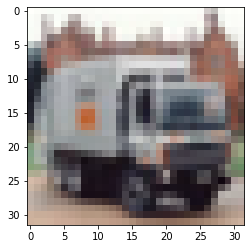

In [ ]:
fig, ax = plt.subplots()
ax.imshow(lists[3][1].reshape(32,32,3))

In [ ]:
dist = pairwise_distances(x_test)

In [ ]:
dist.shape

(10000, 10000)

In [ ]:
dunn(dist, labels)

0.11426923597528559

In [ ]:
silhouette_score(x_test, labels)

0.04862107712878789

#PART 2 USING AUTO ENCODERS ON TRAINING DATA


In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from sklearn.cluster import KMeans

In [ ]:
# Our original dim is 3072, we encode that to 128 and the compression factor is 24
encoding_dimension = 128  

# This is our input image which is of size 3072(flattened 32,32,3)
input_img = Input(shape=(3072,))

# With the help of relu activation we get the encoded representation of the input image
encoded_img = Dense(encoding_dimension, activation='relu')(input_img)

# We get the lossy reconstruction of the image through decoding the encoded image
decoded_img = Dense(3072, activation='sigmoid')(encoded_img)

# Passing the input layer and the output layer to the model
autoencoderModel = Model(input_img, decoded_img)


In [ ]:

encoderModel = Model(input_img, encoded_img)


In [ ]:
# Since we'll pass an input encoded image of size encoding dim
encoded_input = Input(shape=(encoding_dimension,))
# Retrieve the last layer of the autoencoder model which has a size of 3072
decoder_layer = autoencoderModel.layers[-1]
# Create the decoder model with an input of shape 128
decoderModel = Model(encoded_input, decoder_layer(encoded_input))


In [ ]:
autoencoderModel.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoderModel.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
196/196 [==============================] - 12s 55ms/step - loss: 0.6390 - val_loss: 0.6185
Epoch 2/10
196/196 [==============================] - 11s 56ms/step - loss: 0.6109 - val_loss: 0.6062
Epoch 3/10
196/196 [==============================] - 11s 55ms/step - loss: 0.6020 - val_loss: 0.5996
Epoch 4/10
196/196 [==============================] - 11s 55ms/step - loss: 0.5966 - val_loss: 0.5969
Epoch 5/10
196/196 [==============================] - 11s 54ms/step - loss: 0.5931 - val_loss: 0.5914
Epoch 6/10
196/196 [==============================] - 11s 55ms/step - loss: 0.5895 - val_loss: 0.5891
Epoch 7/10
196/196 [==============================] - 11s 55ms/step - loss: 0.5877 - val_loss: 0.5868
Epoch 8/10
196/196 [==============================] - 11s 54ms/step - loss: 0.5860 - val_loss: 0.5861
Epoch 9/10
196/196 [==============================] - 11s 54ms/step - loss: 0.5852 - val_loss: 0.5853
Epoch 10/10
196/196 [==============================] - 11s 54ms/step - loss: 0.584

In [ ]:
encodedImages = encoderModel.predict(x_train)

In [ ]:
encodedImages.shape

(50000, 128)

In [ ]:
newlists = [[] for _ in range(Clustersize)]

In [ ]:
KMModel = KMeans(
    n_clusters=10, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
dataLabels = KMModel.fit_predict(encodedImages)

In [ ]:
dataLabels.shape

(50000,)

In [ ]:
decodedImages = decoderModel.predict(encodedImages)


In [ ]:
for ls in range(0, encodedImages.shape[0]-1):
  newlists[dataLabels[ls]].append(decodedImages[ls]) 

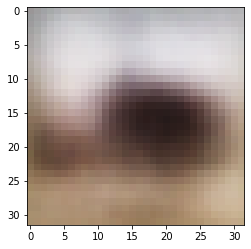

In [ ]:
fig, ax = plt.subplots()
ax.imshow(newlists[3][1].reshape(32,32,3))

In [ ]:
silhouette_score(encodedImages,dataLabels)

0.09092586